# Sentiment Analysis Using BERT on Chinese Dataset

In this tutorial, we show how to perform text classification of spammed mails using the pre-trained BERT model.

This example also shows the effectiveness of **transfer learning**.

## BERT in Short

- BERT is a model with absolute position embeddings so it’s usually advised to pad the inputs on the right rather than the left.

- The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova. 
- It’s a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.
- In particular, BERT was trained with the masked language modeling (MLM) and next sentence prediction (NSP) objectives. It is efficient at predicting masked tokens and at NLU in general, but is not optimal for text generation.
- The size of the large BERT model:
    - Transformer blocks: 24
    - Embedding dimension: 1024
    - Attention heads: 16
    - Total number of parameters: 340M

- The size of GPT-2 Model:
    - Transformer blocks: 48
    - Sequence length: 1024
    - Embedding dimension: 1600
    - Total number of parameters: 1.5B

## Setup

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import sklearn
import unicodedata
import numpy as np
import re

## Data Loading

In [17]:
# def unicode_to_ascii(s):
#     return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# def clean_stopwords_shortwords(w):
#     stopwords_list=stopwords.words('english')
#     words = w.split() 
#     clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
#     return " ".join(clean_words) 

# def preprocess_sentence(w):
#     w = unicode_to_ascii(w.lower().strip())
#     w = re.sub(r"([?.!,¿])", r" ", w)
#     w = re.sub(r'[" "]+', " ", w)
#     w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
#     w=clean_stopwords_shortwords(w)
#     w=re.sub(r'@\w+', '',w)
#     return w

In [2]:
csv_file='../../../RepositoryData/data/marc_movie_review_metadata.csv'
csv_data=pd.read_csv(csv_file,encoding='utf-8')
csv_data.head()

,reviewID,title_CH,title_EN,genre,rating,reviews,reviews_sentiword_seg
0,Review_1,紫羅蘭永恆花園外傳－永遠與自動手記人偶－,Violet Evergarden - Eternity and the Auto Memo...,動畫,negative,唉，踩雷了，浪費時間，不推 唉，踩雷了，浪費時間，不推,唉 ， 踩 雷 了 ， 浪費 時間 ， 不 推 唉 ， 踩 雷 了 ， 浪費 時間 ， 不 推
1,Review_2,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,片長三個小時，只有最後半小時能看，前面真的鋪陳太久，我旁邊的都看到打呼,片長 三個 小時 ， 只有 最後 半 小時 能 看 ， 前面 真的 鋪陳 太久 ， 我 旁邊...
2,Review_3,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,史上之最，劇情拖太長，邊看邊想睡覺...... 1.浩克竟然學會跟旁人一起合照。 2.索爾...,史上 之 最 ， 劇情 拖 太長 ， 邊看邊 想 睡覺 . . . . . . 1. 浩克 ...
3,Review_4,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,難看死ㄌ 難看死了 難看死ㄌ 看到睡著 拖戲拖很長 爛到爆,難看 死 ㄌ 難看 死 了 難看 死 ㄌ 看到 睡著 拖戲 拖 很長 爛 到 爆
4,Review_5,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,連續三度睡著，真的演的太好睡了,連續 三度 睡著 ， 真的 演 的 太 好 睡 了


## Data Preprocessing

In [3]:
print('File has {} rows and {} columns'.format(csv_data.shape[0],csv_data.shape[1]))

File has 3200 rows and 7 columns


In [48]:
# csv_data = csv_data.loc[:, ~csv_data.columns.str.contains('Unnamed: 2', case=False)] 
# csv_data = csv_data.loc[:, ~csv_data.columns.str.contains('Unnamed: 3', case=False)] 
# csv_data = csv_data.loc[:, ~csv_data.columns.str.contains('Unnamed: 4', case=False)] 
# csv_data.head()
# csv_data=csv_data.dropna() 
# csv_data=csv_data.reset_index(drop=True)  # Reset index after dropping the columns/rows with NaN values

In [4]:
csv_data.rename(columns={'rating':'label','reviews':'text'}, inplace=True)

In [5]:
csv_data = sklearn.utils.shuffle(csv_data)                                                         # Shuffle the dataset
#print('Available labels: ',data.label.unique())                              # Print all the unique labels in the dataset
# csv_data['text']=csv_data['text'].map(preprocess_sentence)                           # Clean the text column using preprocess_sentence function defined above

In [6]:
print('File has {} rows and {} columns'.format(csv_data.shape[0],csv_data.shape[1]))
csv_data.head()

File has 3200 rows and 7 columns


,reviewID,title_CH,title_EN,genre,label,text,reviews_sentiword_seg
1694,Review_1695,萬萬沒想到,Chhichhore,劇情_喜劇,positive,"看完這部以後,我人生中最好看的劇又增加了一部,上一部是三個傻瓜,誠心推薦","看完 這部 以後 , 我 人生 中 最 好看 的 劇 又 增加 了 一部 , 上一部 是 三..."
2819,Review_2820,證人,Innocent Witness,劇情,positive,之於驚奇隊長，我會選擇證人，劇情太多層了,之於 驚奇隊長 ， 我 會 選擇 證人 ， 劇情 太多 層 了
2833,Review_2834,返校,Detention,懸疑/驚悚,positive,好看 一堆中國人和韓粉別來亂刷負評阿 事實也是抹滅不了阿,好看 一堆 中國 人 和 韓粉 別來 亂 刷 負評 阿 事實 也是 抹滅 不了 阿
2904,Review_2905,你的情歌,Your love song,劇情,positive,演員演技實力都很好，劇情架構也很棒！,演員 演技 實力 都 很 好 ， 劇情 架構 也 很棒 ！
2304,Review_2305,肥龍過江,Enter The Fat Dragon,動作_喜劇,positive,超想看 《肥龍過江》，因為這部電影感覺好看、好笑、很有意思，非看不可！🙋,超 想 看 《 肥 龍 過 江 》 ， 因為 這部 電影 感覺 好看 、 好笑 、 很 有 ...


## BERT Tokenizer

- You can find more pre-trained models supported by HuggingFace [here](https://huggingface.co/models?filter=zh).
- CKIP has also released their BERT models. Please see [here](https://huggingface.co/ckiplab). 
    - It seems that CKIP only releases the `pytorch` version of the pre-trained models. They are not using Tensorflow unfortunately. 
    - But the general Chinese models come with both versions `bert-base-chinese`. So we will use this general one.


```{tip}
In `transformers`, there are several predefined tensorflow models that use BERT for classification. Please see Hugginface transformers's [BERT](https://huggingface.co/transformers/model_doc/bert.html) documentation.
```

dd

In [7]:
num_classes = len(csv_data.label.unique())
MAX_LEN = 50

from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-chinese",
                                              add_special_tokens=True,
#                                               max_length=MAX_LEN,
                                              pad_to_max_length=True,)

In [8]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese',num_labels=num_classes)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
sent= '天阿，這電影實在是...無言啊！'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['天', '阿', '，', '這', '電', '影', '實', '在', '是', '.', '.', '.', '無', '言', '啊', '！']


Parameters of `TFBertForSequenceClassification` model:
- `input_ids`: The input ids are often the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model. This can be obtained by the BERT Tokenizer.
input_ids (Numpy array or tf.Tensor of shape (batch_size, sequence_length))
Indices of input sequence tokens in the vocabulary.
- `batch_size` : Number of examples or sentences batch
sequence_length : A number of tokens in a sentence.
2. attention_mask (Numpy array or tf.Tensor of shape (batch_size, sequence_length)) –
Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]: 1 for tokens that are not masked, 0 for tokens that are marked (0 if the token is added by padding).
This argument indicates to the model which tokens should be attended to, and which should not.
If we have 2 sentences and the sequence length of one sentence is 8 and another one is 10, then we need to make them of equal length and for that, padding is required. To distinguish between the padded and nonpadded input attention mask is used.
3. labels (tf.Tensor of shape (batch_size,), optional) – Labels for computing the sequence classification/regression loss.
Indices should be in [0, ..., num_classes- 1]. If num_classes == 1 a regression loss is computed (Mean-Square loss), If num_classes > 1 a classification loss is computed (Cross-Entropy).
These tokens can then be converted into IDs which are understandable by the model. This can be done by directly feeding the sentence to the tokenizer.

In [11]:
tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True, max_length =30,padding = True,
return_attention_mask = True)

In [12]:
tokenized_sequence

{'input_ids': [101, 1921, 7350, 8024, 6857, 7442, 2512, 2179, 1762, 3221, 119, 119, 119, 4192, 6241, 1557, 8013, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [31]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] 天 阿 ， 這 電 影 實 在 是... 無 言 啊 ！ [SEP]'

## From Text to BERT Input

In [13]:
csv_data['label_num'] = csv_data['label'].map({'negative':0,'positive':1})
csv_data.head()

,reviewID,title_CH,title_EN,genre,label,text,reviews_sentiword_seg,label_num
1694,Review_1695,萬萬沒想到,Chhichhore,劇情_喜劇,positive,"看完這部以後,我人生中最好看的劇又增加了一部,上一部是三個傻瓜,誠心推薦","看完 這部 以後 , 我 人生 中 最 好看 的 劇 又 增加 了 一部 , 上一部 是 三...",1
2819,Review_2820,證人,Innocent Witness,劇情,positive,之於驚奇隊長，我會選擇證人，劇情太多層了,之於 驚奇隊長 ， 我 會 選擇 證人 ， 劇情 太多 層 了,1
2833,Review_2834,返校,Detention,懸疑/驚悚,positive,好看 一堆中國人和韓粉別來亂刷負評阿 事實也是抹滅不了阿,好看 一堆 中國 人 和 韓粉 別來 亂 刷 負評 阿 事實 也是 抹滅 不了 阿,1
2904,Review_2905,你的情歌,Your love song,劇情,positive,演員演技實力都很好，劇情架構也很棒！,演員 演技 實力 都 很 好 ， 劇情 架構 也 很棒 ！,1
2304,Review_2305,肥龍過江,Enter The Fat Dragon,動作_喜劇,positive,超想看 《肥龍過江》，因為這部電影感覺好看、好笑、很有意思，非看不可！🙋,超 想 看 《 肥 龍 過 江 》 ， 因為 這部 電影 感覺 好看 、 好笑 、 很 有 ...,1


In [14]:
sentences=csv_data['text']
labels=csv_data['label_num']
len(sentences),len(labels)

(3200, 3200)

In [15]:
input_ids=[]
attention_masks=[]
segment_ids =[] 

MAX_LEN = 50
for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(
        sent,add_special_tokens = True, 
        max_length =MAX_LEN,
        pad_to_max_length = True,
        padding='max_length',
        return_attention_mask = True,
        truncation=True
    )
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])
    segment_ids.append(bert_inp['token_type_ids'])

## alvin's note:
## according to the warning, we should use `padding='max_length'` and specificay `max_length = 50`
## to make it work

In [16]:
input_ids=np.asarray(input_ids).astype('int32')
attention_masks=np.array(attention_masks)
segment_ids=np.array(segment_ids)
labels=np.array(labels)

In [17]:
len(input_ids),len(attention_masks),len(labels), len(segment_ids)


(3200, 3200, 3200, 3200)

- BERT Tokenizer returns a dictionary from which we can get the input ids and the attention masks.
- Convert all the encoding to NumPy arrays.
- Arguments of BERT Tokenizer:
    - text (str, List[str], List[List[str]]) – The sequence or batch of sequences to be encoded. Each sequence can be a string or a list of strings (pretokenized string). If the sequences are provided as list of strings (pretokenized), you must set is_split_into_words=True (to lift the ambiguity with a batch of sequences).
    - add_special_tokens (bool, optional, defaults to True) – Whether or not to encode the sequences with the special tokens relative to their model.
    - max_length (int, optional) — Controls the maximum length to use by one of the truncation/padding parameters. (max_length≤512)
    - padding (bool, optional, defaults to True) – Whether or not to pad the sequences to the maximum length.
    - return_attention_mask (bool, optional) –

## Train-Test Split

In [25]:
import sklearn.model_selection
train_inp,val_inp,train_label,val_label,train_mask,val_mask, train_seg, val_seg =sklearn.model_selection.train_test_split(input_ids,labels,attention_masks, segment_ids, test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (2560, 50) Val input shape (640, 50)
Train label shape (2560,) Val label shape (640,)
Train attention mask shape (2560, 50) Val attention mask shape (640, 50)


## Model Setup

In [27]:

import os
path = "./sentiment-analysis-using-bert-keras-chinese/models/"

if not os.path.exists(path):
    os.mkdir(path)

## Callbacks
## The model will automatically create the `log_dir` but not `model_save_path`

In [28]:
log_dir='./sentiment-analysis-using-bert-keras-chinese/tensorboard_data/tb_bert'
model_save_path='./sentiment-analysis-using-bert-keras-chinese/models/bert_model.h5'


callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  102267648 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 102,269,186
Trainable params: 102,269,186
Non-trainable params: 0
_________________________________________________________________

Bert Model None


## Model Training

In [29]:
history=bert_model.fit([train_inp,train_mask],
                       train_label,
                       batch_size=32,
                       epochs=1,
                       validation_data=([val_inp,val_mask],val_label),
                       callbacks=callbacks)

 1/80 [..............................] - ETA: 0s - loss: 0.8381 - accuracy: 0.3750WARNING:tensorflow:From /Users/Alvin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
80/80 [==============================] - 846s 11s/step - loss: 0.4073 - accuracy: 0.8152 - val_loss: 0.2520 - val_accuracy: 0.8984


In [31]:
bert_model.save_weights(model_save_path)

## Model Evaluation Using Tensorbaord

In [144]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir {log_dir}

## Model Evaluation: Metrics

In [42]:
# model_save_path='./sentiment-analysis-using-bert-keras/models/bert_model.h5'


trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)



Some layers from the model checkpoint at bert-base-chinese were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier', 'dropout_75']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [33]:
preds = bert_model.predict([val_inp,val_mask],batch_size=32)
pred_labels = preds[0].argmax(axis=1)
f1 = sklearn.metrics.f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')

target_names=csv_data.label.unique()
print(sklearn.metrics.classification_report(val_label,pred_labels,target_names=target_names))

print('Training and saving built model.....')

F1 score 0.882032667876588
Classification Report
              precision    recall  f1-score   support

    positive       0.86      0.97      0.91       343
    negative       0.96      0.82      0.88       297

    accuracy                           0.90       640
   macro avg       0.91      0.89      0.90       640
weighted avg       0.90      0.90      0.90       640

Training and saving built model.....


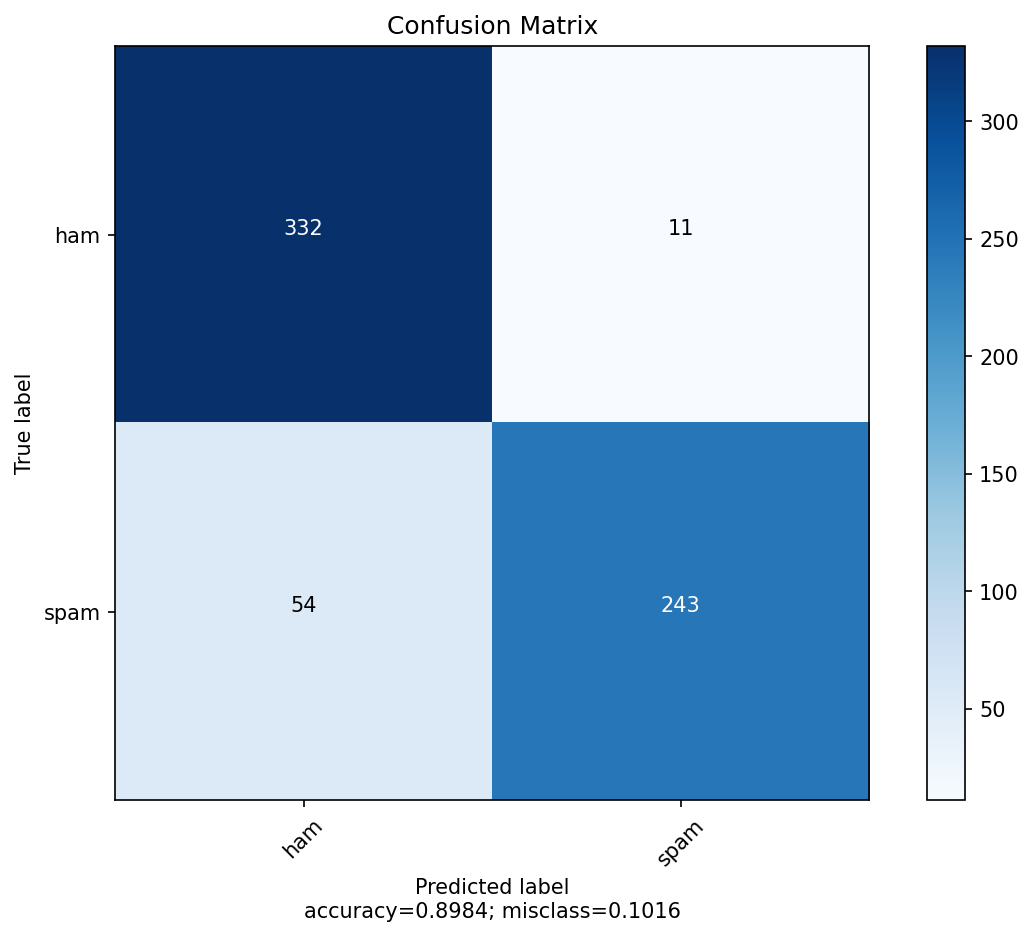

In [34]:
cm = sklearn.metrics.confusion_matrix(val_label, pred_labels, normalize=None)
plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ['ham', 'spam'],
                      title        = "Confusion Matrix")

In [44]:
trained_model.evaluate([val_inp,val_mask],batch_size=32)

20/20 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8781


[0.0, 0.878125011920929]

## Custom Model with BERT

In [36]:
from transformers import TFBertModel

bert_custom = TFBertModel.from_pretrained('bert-base-chinese')
bert_custom.summary()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-chinese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  102267648 
Total params: 102,267,648
Trainable params: 102,267,648
Non-trainable params: 0
_________________________________________________________________


### Define Model Structure

In [37]:
inp_ids = keras.layers.Input((MAX_LEN,), dtype=tf.int64, name="input_ids")
att_mask = keras.layers.Input((MAX_LEN,), dtype=tf.int64, name="attention_mask")
seg_ids = keras.layers.Input((MAX_LEN,), dtype=tf.int64, name="token_type_ids")

inp_dict = {"input_ids": inp_ids,
           "attention_mask": att_mask,
           "token_type_ids": seg_ids}
outputs = bert_custom(inp_dict) ## get the pooled output of each input sequence for fine-tuning

In [38]:
## The output of the each input token includes special token [SEP] and [CLS].
## The second one is [CLS], which is the pooled output of the entire input sequence
outputs

(<tf.Tensor 'tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0' shape=(None, 50, 768) dtype=float32>,
 <tf.Tensor 'tf_bert_model/bert/pooler/dense/Tanh:0' shape=(None, 768) dtype=float32>)

In [39]:
x = keras.layers.Dropout(0.2)(outputs[1])
x = keras.layers.Dense(200, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(2, activation="sigmoid")(x)
custom_model = keras.models.Model(inputs=inp_dict, outputs=x)
custom_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 102267648   attention_mask[0][0]             
                                                                 input_ids[0][0]       

In [40]:
## Fine tune BERT on IMDB

input_dict = {"input_ids": train_inp,
           "attention_mask": train_mask,
           "token_type_ids": train_seg}
val_dict = {"input_ids": val_inp,
           "attention_mask": val_mask,
           "token_type_ids": val_seg}

In [41]:
bert_custom.trainable=False
optimizer = tf.keras.optimizers.Adam() ## standard learning rate
custom_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])
custom_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 102267648   attention_mask[0][0]             
                                                                 input_ids[0][0]       

In [42]:
custom_history = custom_model.fit(input_dict, train_label, batch_size=32,
                       epochs=3,
                       validation_data=(val_dict,val_label))

Epoch 1/3
80/80 [==============================] - 300s 4s/step - loss: 0.6673 - accuracy: 0.5791 - val_loss: 0.6193 - val_accuracy: 0.6016
Epoch 2/3
80/80 [==============================] - 293s 4s/step - loss: 0.5916 - accuracy: 0.6922 - val_loss: 0.4886 - val_accuracy: 0.8234
Epoch 3/3
80/80 [==============================] - 297s 4s/step - loss: 0.5164 - accuracy: 0.7898 - val_loss: 0.4812 - val_accuracy: 0.8313


## References

- [BERT Text Classification Using Keras](https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d)
- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)
- [Text Extraction with BERT](https://keras.io/examples/nlp/text_extraction_with_bert/#text-extraction-with-bert)